# Higher Education Prediction

- Dataset description: Demographic and academic informations from Portugese students coming from two different high schools during the 2005-2006 school year.
- Project description/Goal : Find the variables that best predict the desire to pursue higher education
- Dependent variable to predict : desire to pursue higher education (binary, 0 = no, 1 = yes)
- Method : logistic regression


### Pseudo-code / analysis steps
1. Import required libraries
2. Import dataset
3. Remove rows with missing values
4. Data visualization:
- For each independant/predictive variable, graph of its distribution according to the desire to pursue higher education
5. Encode binary dependent variable (0 or 1) 
6. Encode binary and nominal predictive variables
7. Assumptions check
- Linearity : There should be a linear relationship between each X variable and the logit of the probability that Y equals 1. Check at the end.
- Independent observations -> ok
- No multicollinearity 
- No extreme outliers 
8. Split dataset into train and test sets 
9. Normalization/standardization  
10. Logistic regression

## 1-2. Import required libraries and dataset

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing

df = pd.read_csv('student_modified.csv')
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


## 3. Remove rows with missing values

In [133]:
# Remove rows with missing values
pre_rejet = len(df)
if (df.isna()).sum().sum():            # if at least one missing value in the df
    df_VI = df.dropna(axis = 'index')  # reject rows with missing values
post_rejet = len(df_VI)
print("Rejected", pre_rejet - post_rejet, "participant(s) because of missing value(s).")

Rejected 1 participant(s) because of missing value(s).


In [134]:
# Check the values of each column (make sure that all values are plausible)
for column in df.columns:
    print(column, df[column].unique())

school ['GP' 'MS']
sex ['F' 'M']
age [18 17 15 16 19 22 20 21]
address ['U' 'R']
famsize ['GT3' 'LE3']
Pstatus ['A' 'T']
Medu [4 1 3 2 0]
Fedu [4 1 2 3 0]
Mjob ['at_home' 'health' 'other' 'services' 'teacher']
Fjob ['teacher' 'other' 'services' 'health' 'at_home']
reason ['course' 'other' 'home' 'reputation']
guardian ['mother' 'father' 'other' nan]
traveltime [2 1 3 4]
studytime [2 3 1 4]
failures [0 3 2 1]
schoolsup ['yes' 'no' '1']
famsup ['no' 'yes']
paid ['no' 'yes']
activities ['no' 'yes']
nursery ['yes' 'no']
higher ['yes' 'no']
internet ['no' 'yes']
romantic ['no' 'yes' 'none']
famrel [4 5 3 1 2]
freetime [3 2 4 1 5]
goout [4 3 2 1 5]
Dalc [1 2 5 3 4]
Walc [1 3 2 4 5]
health [3 5 1 2 4]
absences [ 6  4 10  2  0 16 14  7  8 25 12 54 18 26 20 56 24 28  5 13 15 22  3 21
  1 75 30 19  9 11 38 40 23 17 32]
G1 [ 5  7 15  6 12 16 14 10 13  8 11  9 17 19 18  4  3  0]
G2 [ 6  5  8 14 10 15 12 18 16 13  9 11  7 19 17  4  0]
G3 [ 6 10 15 11 19  9 12 14 16  5  8 17 18 13 20  7  0  4  1]


We see that the dataset contains inadequate values:
- guardian: nan
- schoolsup: '1'
- romantic: 'none'

<br>-> remove corresponding rows

In [135]:
# Remove remaining missing values
df = df.drop(df.guardian[df.guardian.isna()].index[0], axis = 0) # Enlever la ligne de la valeur manquante dans 'guardian'
df = df.drop(df.romantic[df.romantic == 'none'].index[0], axis = 0) # Enlever la ligne de la valeur manquante dans 'romantic'
df = df.drop(df.schoolsup[df.schoolsup == '1'].index[0], axis = 0) # Enlever la ligne de la valeur manquante dans 'romantic'

## 4. Data visualization 
- Groupby: Visualization of the mean of numerical and ordinal independent variables according to the desire to pursue higher education
    - This supposes equal intervals between values of ordinal variables, which is not the case (eg. failures). This is just used to get a global picture of the data. 

In [136]:
df.groupby('higher').mean() 

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
higher,,,,,,,,,,,,,,,,
no,17.719101,1.842697,1.696629,1.719101,1.460674,0.876404,3.808989,3.494382,3.393258,1.831461,2.651685,3.505618,5.910112,8.561798,8.550562,8.348315
yes,16.636555,2.674370,2.451681,1.503151,2.017857,0.205882,3.948529,3.174370,3.136555,1.463235,2.252101,3.544118,4.269958,11.461134,11.495798,11.618697


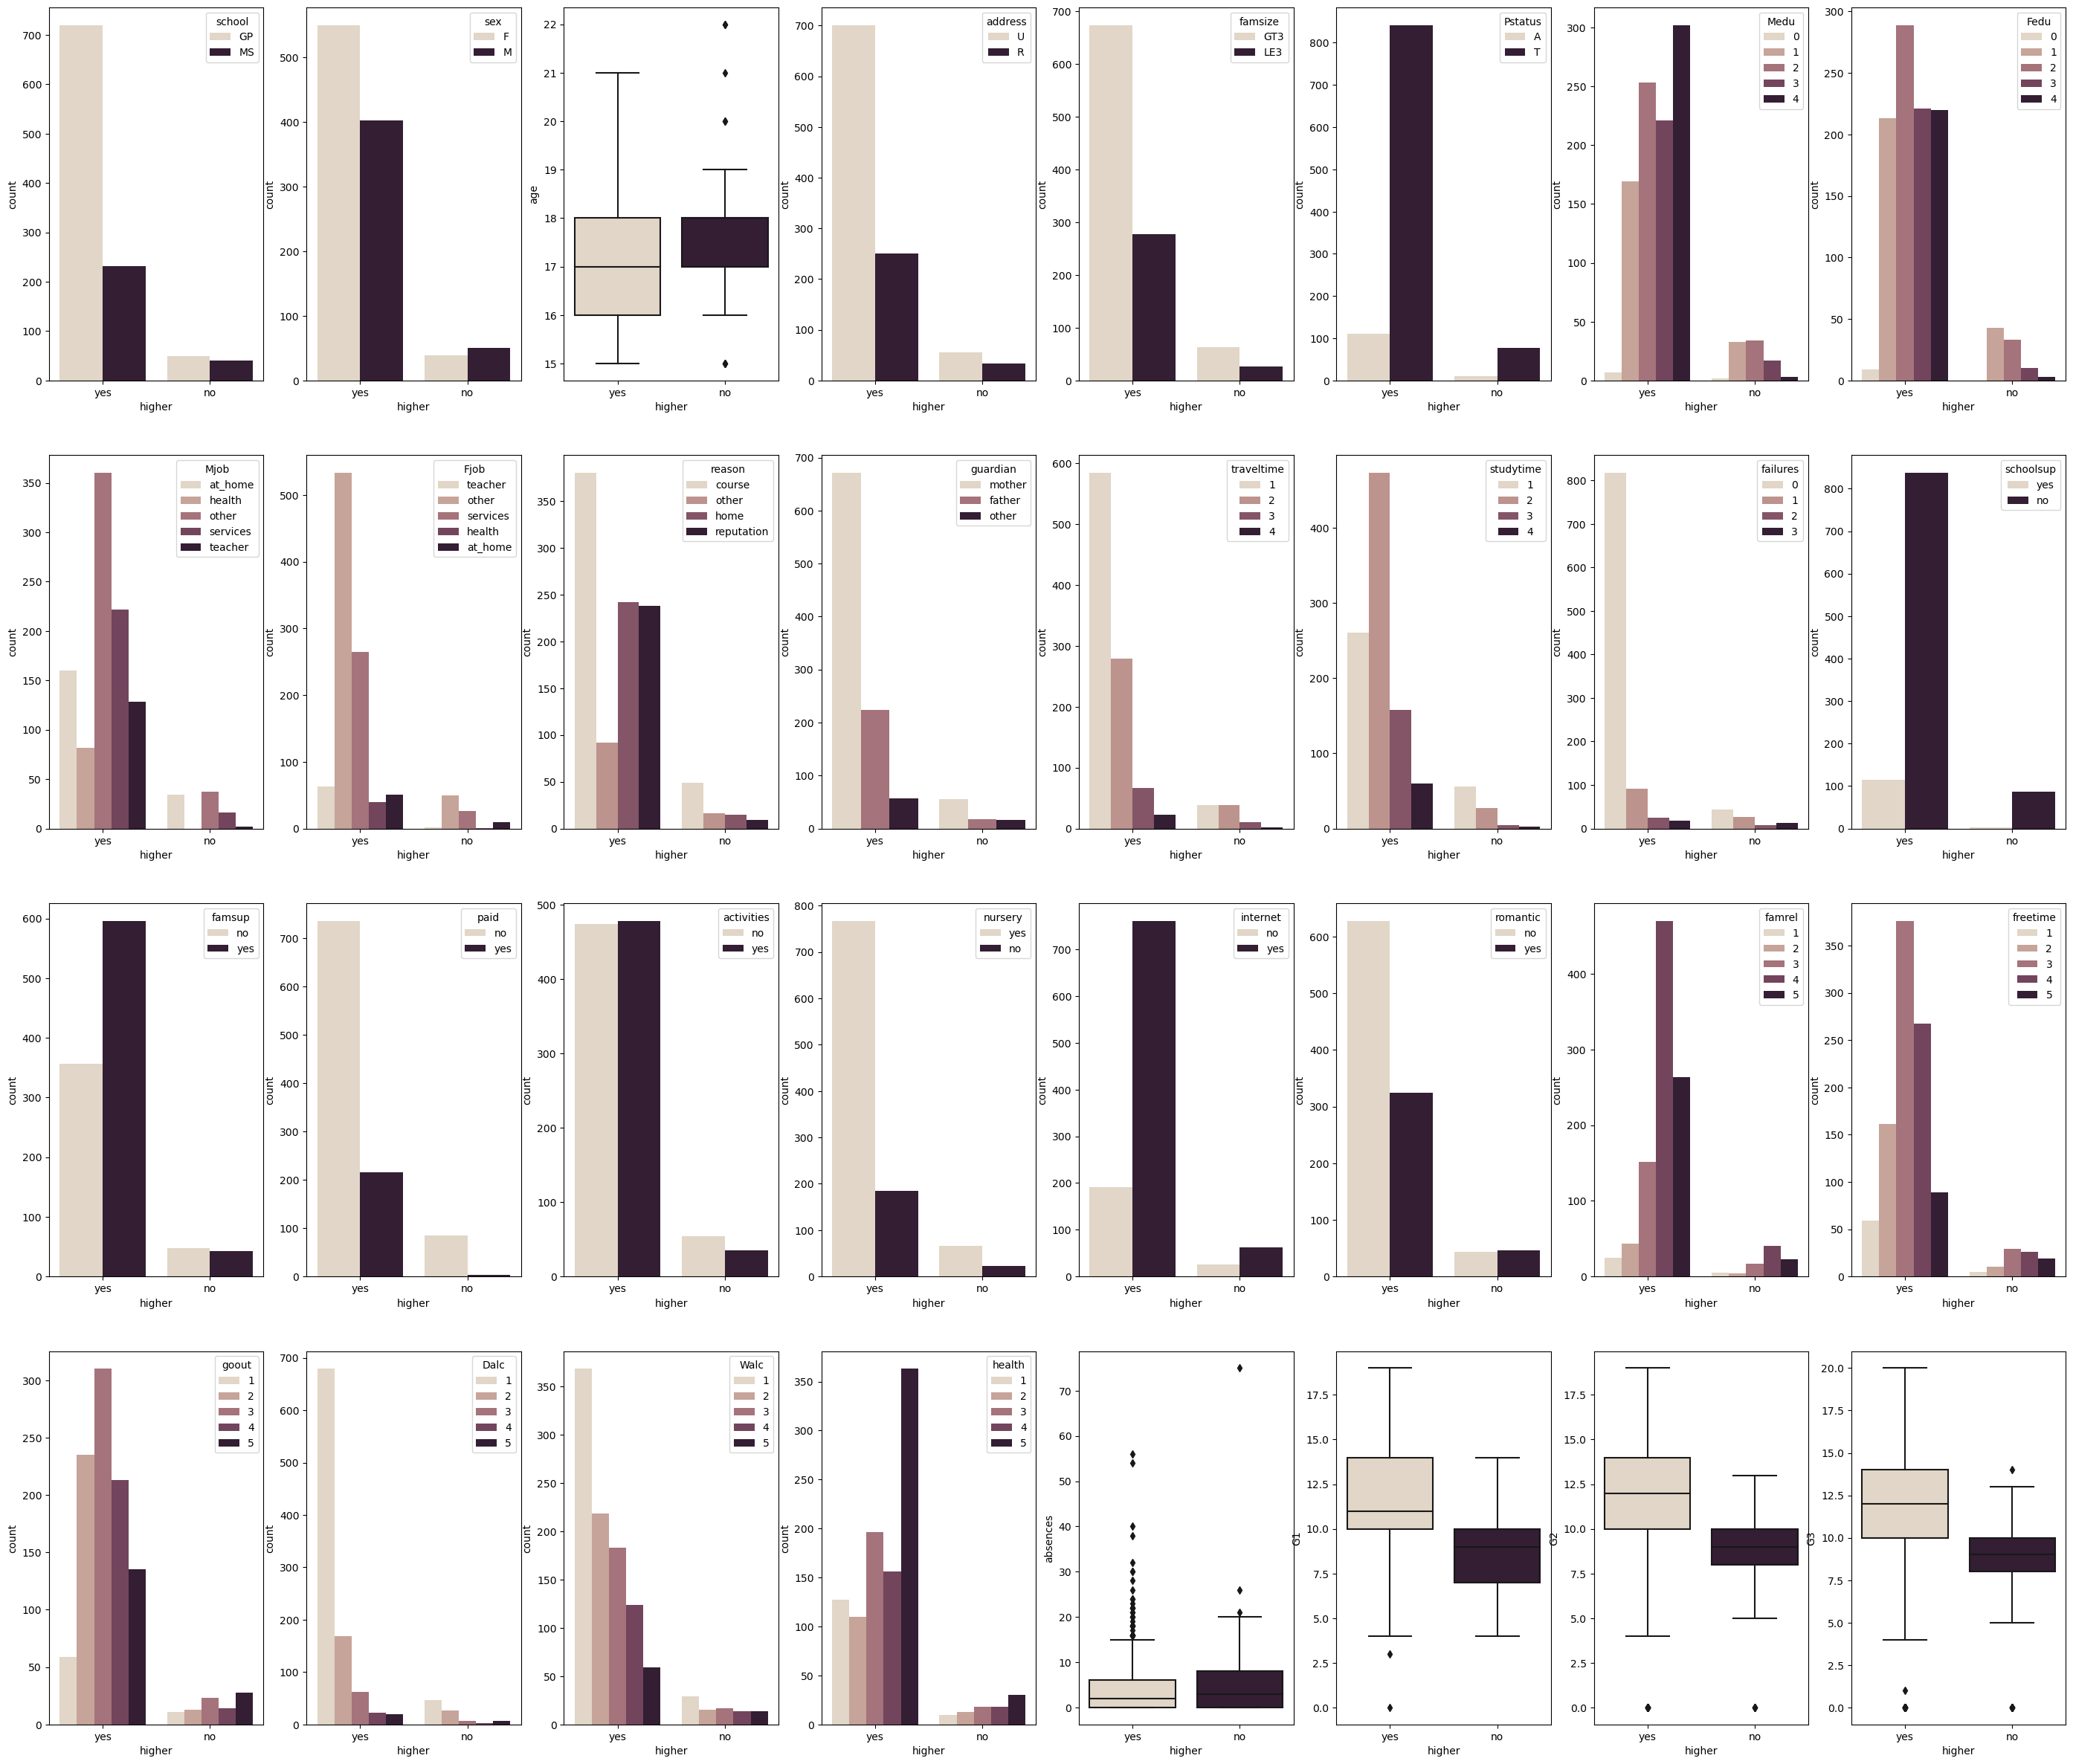

In [137]:
numerical_var = ['age', 'absences', 'G1', 'G2', 'G3']
ord_cat_var = df.columns.drop(numerical_var + ['higher'])

n_rows = 4
n_cols = len(df.columns.drop('higher'))//n_rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(35, 30))

current_row = 0
current_col = 0

for col in df.columns.drop('higher'):
    if col in numerical_var:
        sns.boxplot(ax = axes[current_row, current_col], data = df, x = "higher", y = col, palette = "ch:.25") 

    elif col in ord_cat_var:
        sns.countplot(ax = axes[current_row, current_col], x = 'higher', hue = col, data = df, palette = "ch:.25") 
    else:
        print(col)

    current_col+=1

    if current_col==n_cols:
        current_row+=1
        current_col=0

plt.show()

Observations : 
- Variables that do not seem to impact the desire to pursue higher education (similar distribution for 'yes' and 'no') : age, address, famsize, Pstatus, Mjob, Fjob, reason, guardian, traveltime, schoolsup, paid, activities, nursery, internet, famrel, freetime, Dalc, Walc, health, absences -> not included in the model
- Variables potentially predictive of desire to pursue higher education : school, sex, Medu, Fedu, studytime, failure, famsup, romantic, goout, G1, G2, G3

Hypothesis: Variables that can best predict the desire to pursue higher education are : school, sex, Medu, Fedu, studytime, failure, famsup, romantic, goout, G1, G2, G3. 

[Text(0.5, 1.0, 'Distribution of the dependent variable (desire to pursue higher education)')]

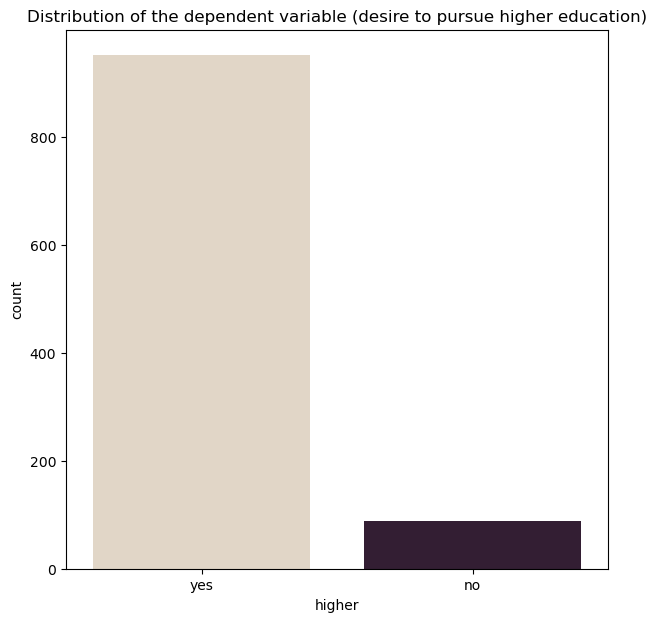

In [138]:
sns.countplot(x = 'higher', data = df, palette = "ch:.25").set(title = "Distribution of the dependent variable (desire to pursue higher education)")

Observation : 
- Distribution very unequal between yes and no categories. Unbalanced classes. 

## 5. Encode binary dependent variable (0 or 1) 

In [139]:
df_copy = df.copy()

In [140]:
df['higher'].replace(['no', 'yes'], [0, 1], inplace = True)

## 6. Encode binary and nominal predictive variables

In [141]:
le = preprocessing.LabelEncoder()

for var in df.columns.drop('higher'):
    df[var] = le.fit_transform(df[var])

## 7. Assumptions check

### Multicollinearity

In [142]:
# Generate a correlation matrix
corr_matrix = df.corr(method='pearson')

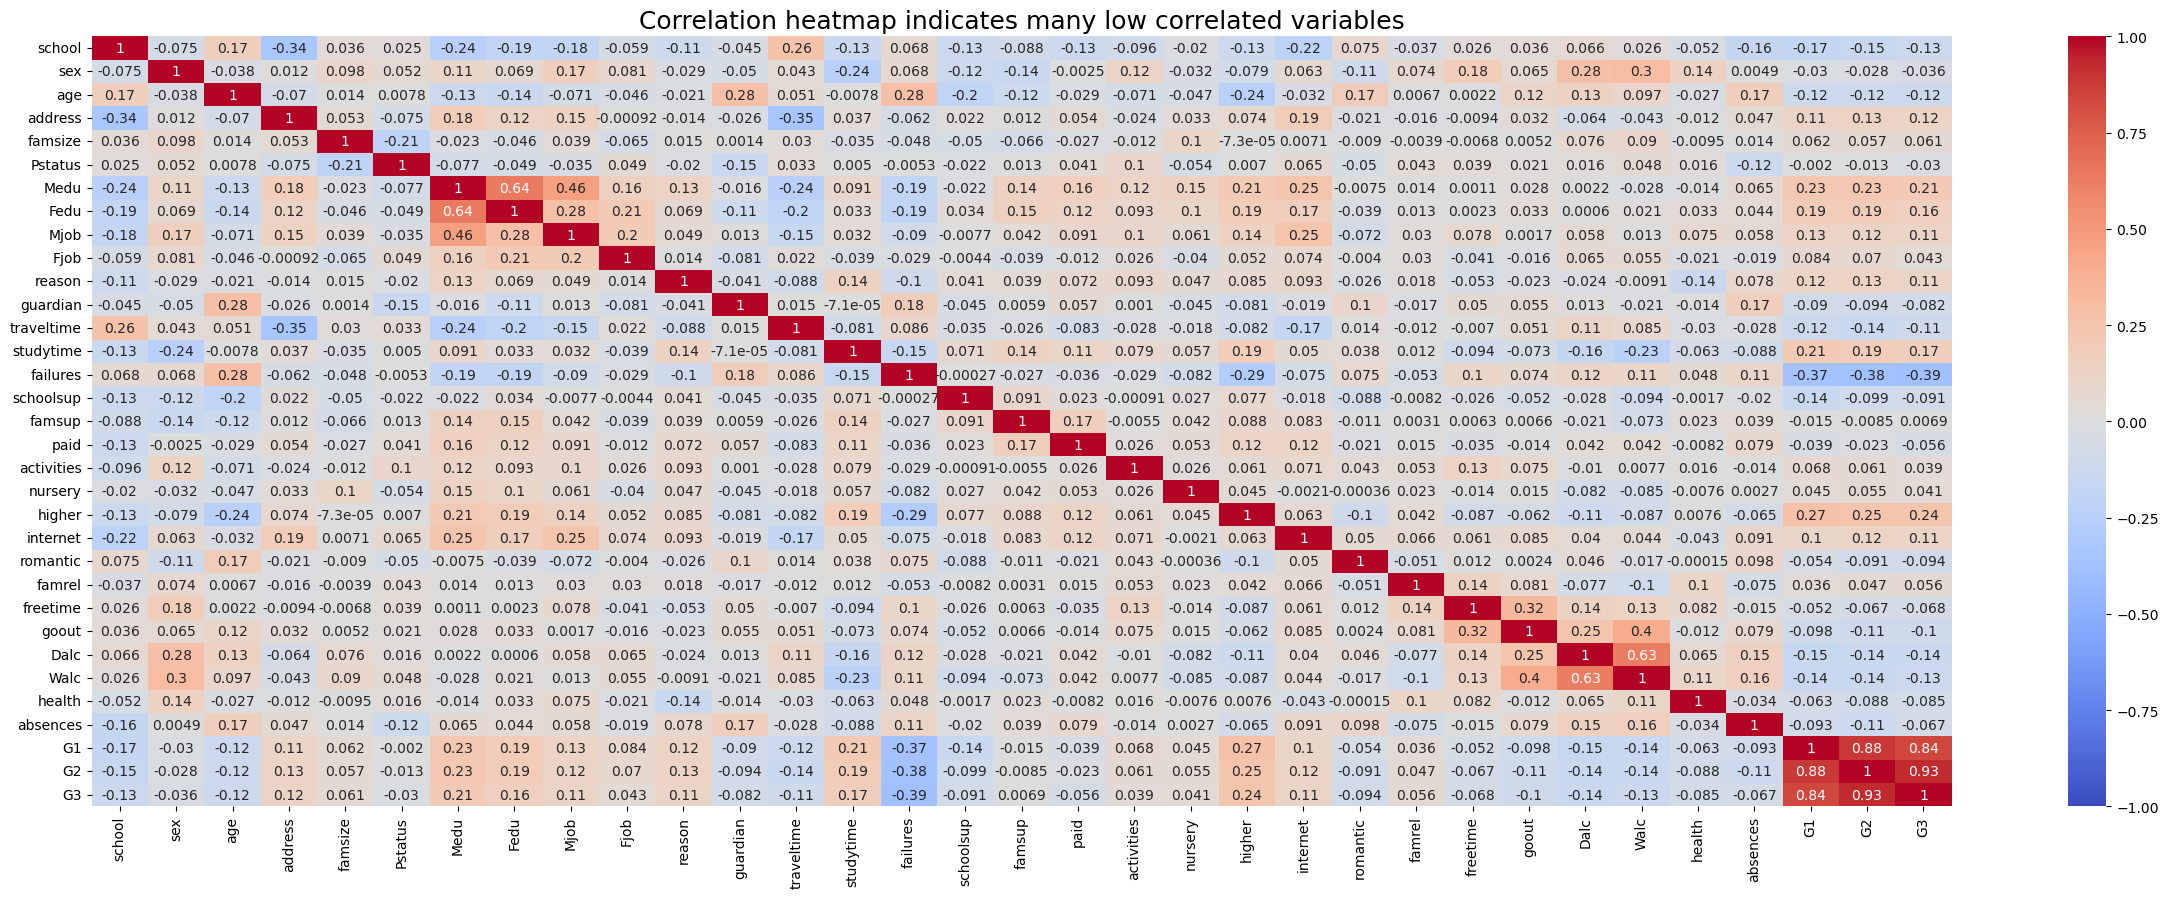

In [143]:
# Plot correlation heatmap
plt.figure(figsize=(30,10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap indicates many low correlated variables',
          fontsize=18)
plt.show()

Predictor variables that have a Pearson correlation coefficient value greater than the **absolute value of 0.7** are strongly multicollinear : G1, G2 and G3

In [144]:
vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
  
vif_data["VIF"] = [variance_inflation_factor(df.values, i) # Score VIF pour chaque feature
                          for i in range(len(df.columns))]

vif_data

,feature,VIF
0,school,1.742781
1,sex,2.401362
2,age,3.979452
3,address,4.412956
4,famsize,1.558256
5,Pstatus,8.652162
6,Medu,14.023329
7,Fedu,10.504277
8,Mjob,5.151202
9,Fjob,8.269755


Variables highly correlated (VIF score > 10): 
- G1, G2, G3 -> create average score
- Medu, Fedu -> can't average since they are ordinal and not equally spaced. Will only keep Medu because it is more correlated to the dependent variable 'higher'
- Famrel : Keep even if VIF high because correlations with other variables are ok


In [145]:
# Average G1, G2, G3
df['G_moy'] = df[['G1', 'G2', 'G3']].mean(axis = 1) 
df = df.drop(['G1', 'G2', 'G3'], axis = 1) 

# Drop Fedu
df = df.drop(['Fedu'], axis = 1)

### No outliers
For numerical variables, compute the **95th percentile** of each column and change to this value any value in the column that exceeds it.

In [146]:
# Impute outliers
for column in ['age', 'absences', 'G_moy']:
    threshold = df[column].quantile(0.95)
    df.loc[df[column] > threshold, column] = threshold

## 7. Split dataset in train and test sets

In [147]:
X = df.loc[:, df.columns != 'higher']
y = df['higher']

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state = 42)

## 9. Normalization/standardization

In [149]:
scaler = preprocessing.StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 10. Logistic regression

In [150]:
model = LogisticRegression(class_weight = 'balanced') # 'balanced' class weight: ajusts weights for unbalanced classes
model.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced')

In [151]:
coef = {}
for i in range(len(X_train.columns)):
    coef[X_train.columns[i]] = model.coef_.flatten()[i] 
coef = dict(sorted(coef.items(), key=lambda item: abs(item[1]))) # sorted coefficients

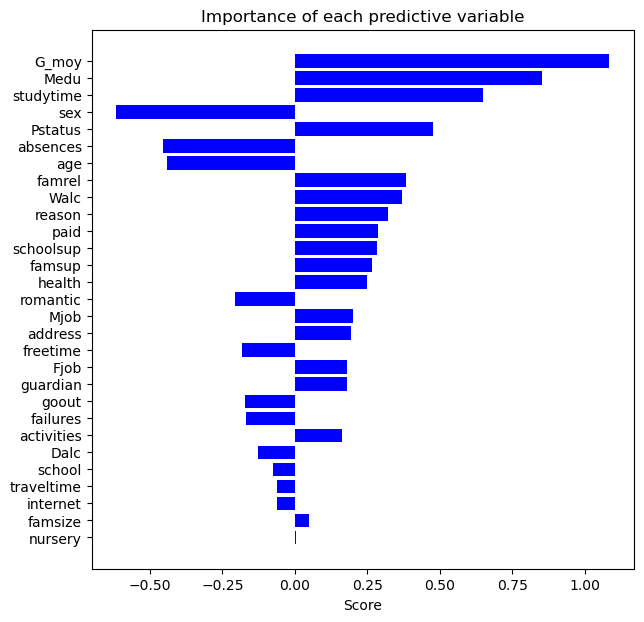

In [152]:
# feature importance
plt.rcParams["figure.figsize"] = (7, 7)
plt.barh(list(coef.keys()), coef.values(), color = 'b')
plt.title('Importance of each predictive variable')
plt.xlabel('Score')
plt.show()

Observations:
- Variables that best predict the desire to pursue higher education are G_moy, Medu, Studytime, sex, Pstatus
- From those, G_moy, Medu, Studytime and Pstatus are positively linked to the desire to pusrue higher education. 
- On the contrary, sex is negatively linked to the desire to pursue higher education 

- The initial hypothesis is partially supported by the results : ses, Medu, studytime and G_moy are in the variables that can best predict the desire to pursue higher education.


## 7. Assumptions check 
### Linearity
In logistic regression, the relationship between a predictor variable and the dependent variable does not need to be linear, however, the log-odds (a.k.a., logit) of the dependent variable with respect to the predictor variable should be linear. Here is the formula for calculating log-odds, where _p_ is the probability of response:
<br>
$$
logit(p) = ln(\frac{p}{1-p})
$$
<br>

In [153]:
# Get the predicted probabilities of the training data
training_probabilities = model.predict_proba(X_train)

/Users/alp/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [154]:
# 1. Copy the `X_train` dataframe and assign to `logit_data`
logit_data = X_train.copy()

# 2. Create a new `logit` column in the `logit_data` df
logit_data['logit'] = [np.log(prob[1] / prob[0]) for prob in training_probabilities]

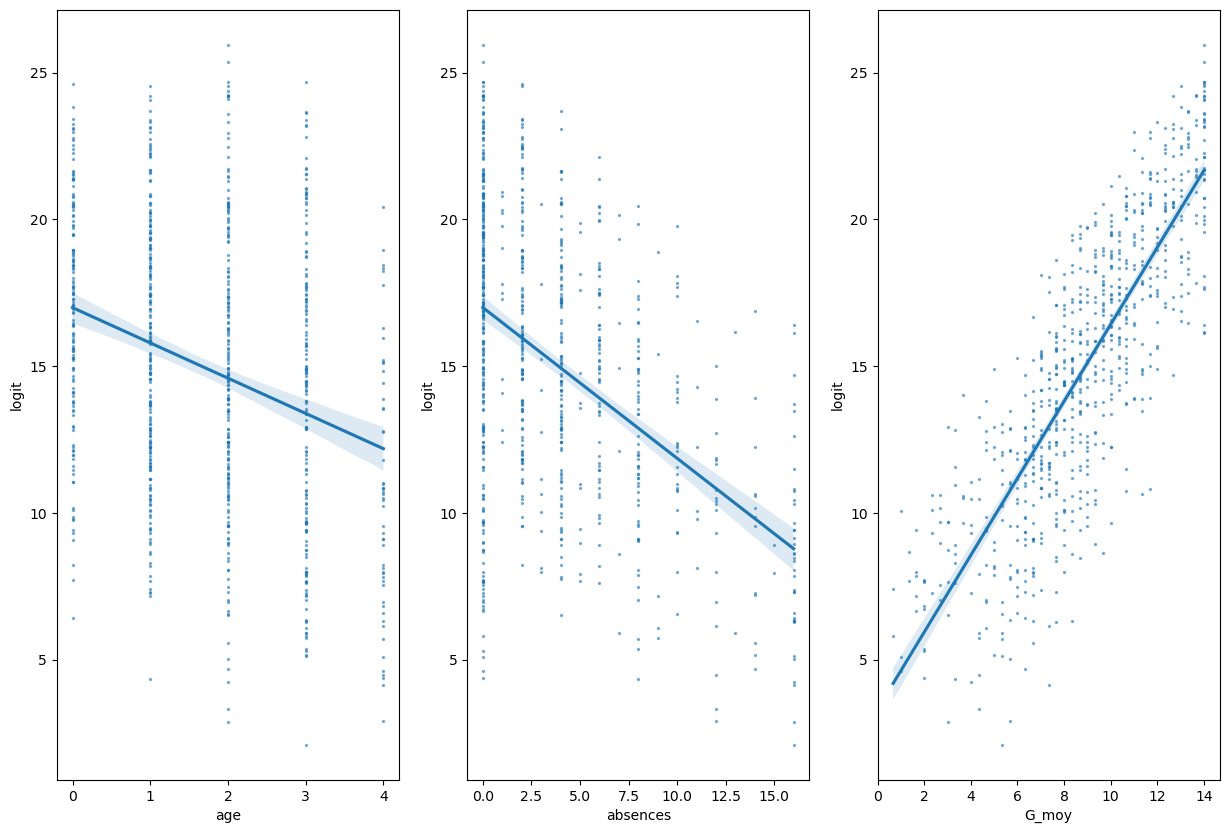

In [155]:
fig, axes = plt.subplots(1, len(numerical_var_updated), figsize=(15, 10))

sns.regplot(x='age', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5}, ax = axes[0])
sns.regplot(x='absences', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5,},ax = axes[1])
sns.regplot(x='G_moy', y='logit', data=logit_data, scatter_kws={'s': 2, 'alpha': 0.5},ax = axes[2])

plt.show()

All plots show relatively linear relationship, so linearity assumption is checked.

In [156]:
prediction = model.predict(scaled_x_test)
print(classification_report(y_test, prediction))
print('accuracy score:', accuracy_score(y_test, prediction))
print(confusion_matrix(y_test, prediction))

              precision    recall  f1-score   support

           0       0.24      0.62      0.35        21
           1       0.96      0.83      0.89       240

    accuracy                           0.81       261
   macro avg       0.60      0.72      0.62       261
weighted avg       0.90      0.81      0.85       261

accuracy score: 0.8122605363984674
[[ 13   8]
 [ 41 199]]


* Precision = TruePositives / (TruePositives + FalsePositives)
    * Precision is higher for category 1
* Recall = TruePositives / (TruePositives + FalseNegatives)
    * Recall is higher for category 1
* F1 = 2 * (precision * recall) / (precision + recall) (best = 1, worst = 0)
    * F1 is higher for category 1

Confusion matrix :
<br>TN FP
<br>FN TP

Observations :
* Lot of True positives : model is good at predicting students who want to pursue higher education
* But lot of False negative : model often wrongly predicts non-desire to pursue higher education 
* Few False positive : model rarely wrongly predicts desire to pursue higher study 